In [ ]:
!pip install python-whois

     |████████████████████████████████| 91 kB 8.7 MB/s 
  Created wheel for python-whois: filename=python_whois-0.7.3-py3-none-any.whl size=87721 sha256=ba9b84f2191770c03c433b22e6434773f0bf434d9bbe963f371f187595c2e7cd
  Stored in directory: /root/.cache/pip/wheels/11/05/f7/895ce5a73665f77c8274a7d55e34fb3e6b4abbb9a7637e215b
Successfully built python-whois


In [ ]:
import pandas as pd
import itertools
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
import math
from collections import Counter
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import xgboost as xgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import socket
import whois
from datetime import datetime
import time
from bs4 import BeautifulSoup
import urllib
import bs4

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/malicious_phish.csv')
print(df.shape)
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
df.type.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [ ]:
import re
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))
from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [ ]:
from googlesearch import search
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))
df['count.'] = df['url'].apply(lambda i: i.count('.'))
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.
0,br-icloud.com.br,phishing,0,0,1,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2


In [ ]:
df['count-www'] = df['url'].apply(lambda i: i.count('www'))
df['count@'] = df['url'].apply(lambda i: i.count('@'))
from urllib.parse import urlparse
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')
df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

df['count-https'] = df['url'].apply(lambda i : i.count('https'))
df['count-http'] = df['url'].apply(lambda i : i.count('http'))
df['count%'] = df['url'].apply(lambda i: i.count('%'))
df['count?'] = df['url'].apply(lambda i: i.count('?'))
df['count-'] = df['url'].apply(lambda i: i.count('-'))
df['count='] = df['url'].apply(lambda i: i.count('='))
#Length of URL
df['url_length'] = df['url'].apply(lambda i: len(str(i)))
#Hostname Length
df['hostname_length'] = df['url'].apply(lambda i: len(urlparse(i).netloc))
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,count%,count?,count-,count=,url_length,hostname_length
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,0,0,0,0,0,1,0,16,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,0,0,0,0,0,0,0,35,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,0,0,0,0,0,0,0,31,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,0,0,1,0,1,1,4,88,21
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,0,0,1,0,1,1,3,235,23


In [ ]:
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,count%,count?,count-,count=,url_length,hostname_length,sus_url
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,0,0,0,0,0,1,0,16,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,0,0,0,0,0,0,0,35,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,0,0,0,0,0,0,0,31,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,0,0,1,0,1,1,4,88,21,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,0,0,1,0,1,1,3,235,23,0


In [ ]:
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url'],
      dtype='object')

In [ ]:
!pip install tld

     |████████████████████████████████| 412 kB 22.2 MB/s 


In [ ]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
df['count-digits']= df['url'].apply(lambda i: digit_count(i))
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
df['count-letters']= df['url'].apply(lambda i: letter_count(i))
df = df.drop("tld",1)
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url', 'fd_length', 'tld_length',
       'count-digits', 'count-letters'],
      dtype='object')

In [ ]:
df['type'].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()

0    428103
1     96457
3     94111
2     32520
Name: type_code, dtype: int64

In [ ]:
#Predictor Variables
X = df[['use_of_ip','abnormal_url', 'google_index', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']
X.head()

,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,count%,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,0,0,1,2,0,0,0,0,0,0,0,0,0,1,0,16,0,0,0,-1,0,13
1,0,0,1,2,0,0,2,0,0,0,0,0,0,0,0,35,0,0,5,-1,1,29
2,0,0,1,2,0,0,3,0,0,0,0,0,0,0,0,31,0,0,7,-1,1,25
3,0,1,1,3,1,0,1,0,0,0,1,0,1,1,4,88,21,0,9,2,7,63
4,0,1,1,2,0,0,1,0,0,0,1,0,1,1,3,235,23,0,9,3,22,199


In [ ]:
X.head()

,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,count%,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,0,0,1,2,0,0,0,0,0,0,0,0,0,1,0,16,0,0,0,-1,0,13
1,0,0,1,2,0,0,2,0,0,0,0,0,0,0,0,35,0,0,5,-1,1,29
2,0,0,1,2,0,0,3,0,0,0,0,0,0,0,0,31,0,0,7,-1,1,25
3,0,1,1,3,1,0,1,0,0,0,1,0,1,1,4,88,21,0,9,2,7,63
4,0,1,1,2,0,0,1,0,0,0,1,0,1,1,3,235,23,0,9,3,22,199


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)
lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt',n_jobs = 5, 
          silent = True, random_state=5)
LGB_C = lgb.fit(X_train, y_train)
y_pred = LGB_C.predict(X_test)
print(classification_report(y_test,y_pred))
score = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     85621
           1       0.96      0.99      0.97     19292
           2       0.96      0.89      0.92      6504
           3       0.90      0.81      0.85     18822

    accuracy                           0.96    130239
   macro avg       0.95      0.92      0.93    130239
weighted avg       0.95      0.96      0.95    130239

accuracy:   0.956


In [ ]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
  if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
  else:
        print('Confusion matrix, without normalization')
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [ ]:
lgb_feature = lgb.feature_importances_
lgb_feature

array([  26,   53,    0,  994,  512,   73, 1171,   45,  147,  304,  157,
        252,  196,  571,  453, 1017, 1509,  293, 1790,  665, 1069,  703])

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     85621
           1       0.89      0.96      0.92     19292
           2       0.92      0.76      0.83      6504
           3       0.88      0.73      0.80     18822

    accuracy                           0.93    130239
   macro avg       0.91      0.86      0.88    130239
weighted avg       0.93      0.93      0.93    130239

accuracy:   0.932
Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  del sys.path[0]


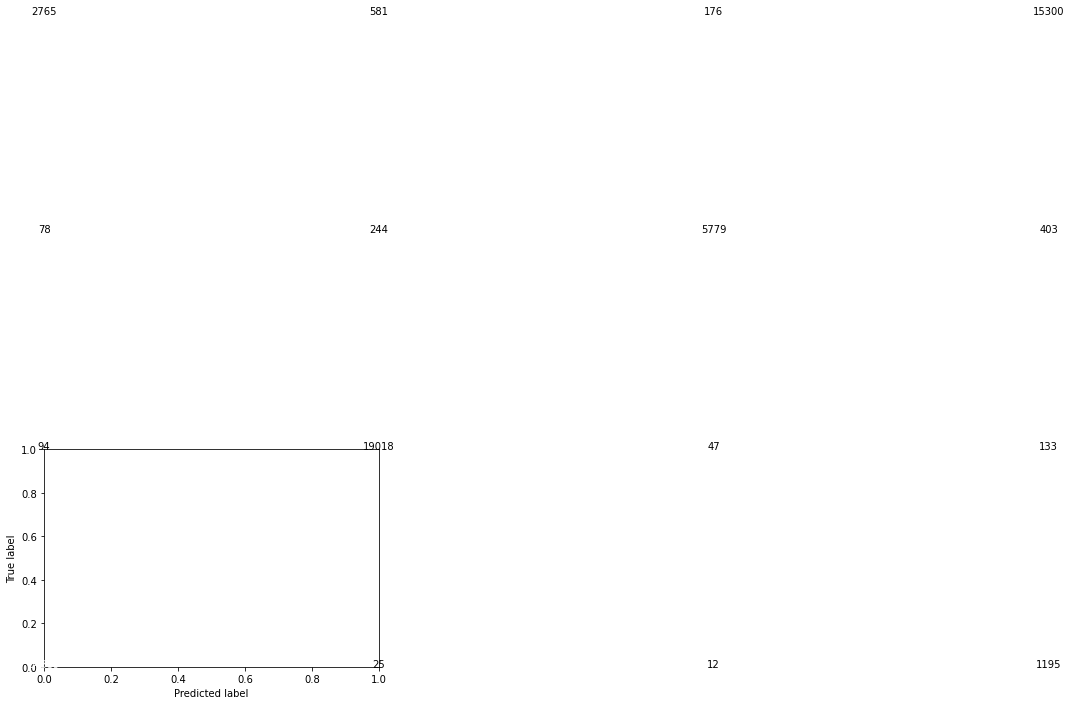

In [ ]:
model = xgb.XGBClassifier(n_estimators= 100)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))
score = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)
CM=confusion_matrix(y_test,y_pred,labels=[0,1,2,3])
plot_confusion_matrix(cm,classes=['benign', 'defacement','phishing','malware'])